#Scraping reddit site and running NLP model

In [ ]:
!pip install praw --quiet

     |████████████████████████████████| 188 kB 7.1 MB/s 
     |████████████████████████████████| 55 kB 1.9 MB/s 


In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display
import random as rand
# misc
import datetime as dt
from pprint import pprint
from itertools import chain

# reddit crawler
import praw
from praw.models import MoreComments
# sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, RegexpTokenizer # tokenize words
from nltk.corpus import stopwords

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) # default plot size
import seaborn as sns
sns.set(style='whitegrid', palette='Dark2')
from wordcloud import WordCloud

In [ ]:
nltk.download('vader_lexicon') # get lexicons data
nltk.download('punkt') # for tokenizer
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
r = praw.Reddit(user_agent='your_user_name',
                client_id='yFDHmbE_xcg4dXoEoRHvfA',
                client_secret='1_S98ykgranjq-nXpqXDWeWo2XIAYQ',
                check_for_async=False)

In [ ]:
def scrape_and_ready_data(reddit_page,post_limit = 100):
  subreddit = r.subreddit(reddit_page)
  page = [*subreddit.top(limit=post_limit)] # top posts all time
  print(reddit_page + ': ' + str(len(page)))
  print(vars(page[0]))
  # create lists of the information from each news
  title = []
  article = []
  author = []
  dateCreated = []
  numComments = []
  upvotes = []
  totalAwards = []
  domain = []
    

  top_comments = []
  top_comments_upvotes = []
  secondary_comments = []
  secondary_comments_upvotes = []
  third_comments = []
  third_comments_upvotes = []
  i = 0
  for submission in page:
    post = submission
    title.append(post.title)
    article.append(post.url)
    author.append(post.author)
    dateCreated.append(dt.datetime.fromtimestamp(post.created))
    numComments.append(post.num_comments)
    upvotes.append(post.score)
    totalAwards.append(post.total_awards_received)
    domain.append(post.domain)


    post.comment_sort = "top"
    post.comments.replace_more(limit=0)
    if post.comments[0].stickied:
      top_comments.append(post.comments[1].body)
      top_comments_upvotes.append(post.comments[1].score)
      secondary_comments.append(post.comments[2].body)
      secondary_comments_upvotes.append(post.comments[2].score)
      third_comments.append(post.comments[3].body)
      third_comments_upvotes.append(post.comments[3].score)
    else:
      top_comments.append(post.comments[0].body)
      top_comments_upvotes.append(post.comments[0].score)
      secondary_comments.append(post.comments[1].body)
      secondary_comments_upvotes.append(post.comments[1].score)
      third_comments.append(post.comments[2].body)
      third_comments_upvotes.append(post.comments[2].score)
    i += 1
    print(i)
  

  page = pd.DataFrame({
    "title": title,
    "article" : article,
    "author" : author,
    "domain" : domain,
    "date_created" : dateCreated,
    "num_comments" : numComments,
    "post_score" : upvotes,
    "total_awards" : totalAwards,
    "top_comment" : top_comments,
    "top_comment_score" : top_comments_upvotes,
    "second_comment" : secondary_comments,
    "second_comment_score" : secondary_comments_upvotes,
    "third_comment" : third_comments,
    "third_comment_score" : third_comments_upvotes,
  })
  display(page.head())
  return page


In [ ]:
worldnews = scrape_and_ready_data('worldnews')

In [ ]:
sid = SentimentIntensityAnalyzer()

In [ ]:
def generate_polarity_scores(page_dataframe):
  res = [*page_dataframe['title'].apply(sid.polarity_scores)]
  sentiment_df = pd.DataFrame.from_records(res)
  page_dataframe = pd.concat([page_dataframe, sentiment_df], axis=1, join='inner')
  display(page_dataframe.head())
  return page_dataframe

In [ ]:
worldnews = generate_polarity_scores(worldnews)

,title,article,author,domain,date_created,num_comments,post_score,total_awards,top_comment,top_comment_score,second_comment,second_comment_score,third_comment,third_comment_score,neg,neu,pos,compound
0,An anti-gay Hungarian politician has resigned ...,https://www.businessinsider.com/hungarian-mep-...,stem12345679,businessinsider.com,2020-12-01 18:15:32,8438,204544,1444,"Officers, thank god you're here! Those men, th...",33806,25 men is a lot of men for a homophobe,26564,> A source in the local police told the newspa...,20213,0.118,0.882,0.000,-0.2500
1,Trump Impeached for Abuse of Power,https://www.nytimes.com/interactive/2019/12/18...,MachoNachoTaco,nytimes.com,2019-12-19 01:23:35,20130,202897,581,UPDATE: vote on impeachment for Obstruction of...,25995,Friendly reminder to vote in the next election...,20397,Okay for everyone wondering what impeachment i...,15937,0.457,0.543,0.000,-0.6369
2,Vladimir Putin's black belt revoked by interna...,https://www.newsweek.com/vladimir-putins-black...,bichonista,newsweek.com,2022-02-28 20:45:18,6961,200156,260,That’s the funniest sanction I’ve ever seen,37492,The sanctions are getting fucking brutal,36521,I'm sorry I know the situation is serious but ...,10935,0.000,1.000,0.000,0.0000
3,"Two weeks before his inauguration, Donald J. T...",https://www.nytimes.com/2018/07/18/world/europ...,DoremusJessup,nytimes.com,2018-07-19 02:06:35,18086,189350,80,This seems like kind of a big deal.,25329,It still baffles me this is real life.,16727,Upvote this shit to the top so everyone knows ...,14609,0.000,0.902,0.098,0.5233
4,"Queen Elizabeth II has died, Buckingham Palace...",https://www.bbc.co.uk/news/uk-61585886,pipsdontsqueak,bbc.co.uk,2022-09-08 17:32:06,16782,188654,99,She reigned for 30% of the existence of the Un...,20618,It is so weird hearing the BBC reporters talki...,20507,"Queen's first PM was Churchill, who was born 1...",18835,0.340,0.660,0.000,-0.5574


In [ ]:
def add_sentiment_labels(page_dataframe, threshold = 0.2):

  conditions = [
    (page_dataframe['compound'] <= -threshold),
    (page_dataframe['compound'] > -threshold) & (page_dataframe['compound'] < threshold),
    (page_dataframe['compound'] >= threshold),
    ]

  values = ["neg", "neu", "pos"]
  page_dataframe['label'] = np.select(conditions, values)

  display(page_dataframe.head())
  return page_dataframe

In [ ]:
worldnews = add_sentiment_labels(worldnews)

,title,article,author,domain,date_created,num_comments,post_score,total_awards,top_comment,top_comment_score,second_comment,second_comment_score,third_comment,third_comment_score,neg,neu,pos,compound,label
0,An anti-gay Hungarian politician has resigned ...,https://www.businessinsider.com/hungarian-mep-...,stem12345679,businessinsider.com,2020-12-01 18:15:32,8438,204544,1444,"Officers, thank god you're here! Those men, th...",33806,25 men is a lot of men for a homophobe,26564,> A source in the local police told the newspa...,20213,0.118,0.882,0.000,-0.2500,neg
1,Trump Impeached for Abuse of Power,https://www.nytimes.com/interactive/2019/12/18...,MachoNachoTaco,nytimes.com,2019-12-19 01:23:35,20130,202897,581,UPDATE: vote on impeachment for Obstruction of...,25995,Friendly reminder to vote in the next election...,20397,Okay for everyone wondering what impeachment i...,15937,0.457,0.543,0.000,-0.6369,neg
2,Vladimir Putin's black belt revoked by interna...,https://www.newsweek.com/vladimir-putins-black...,bichonista,newsweek.com,2022-02-28 20:45:18,6961,200156,260,That’s the funniest sanction I’ve ever seen,37492,The sanctions are getting fucking brutal,36521,I'm sorry I know the situation is serious but ...,10935,0.000,1.000,0.000,0.0000,neu
3,"Two weeks before his inauguration, Donald J. T...",https://www.nytimes.com/2018/07/18/world/europ...,DoremusJessup,nytimes.com,2018-07-19 02:06:35,18086,189350,80,This seems like kind of a big deal.,25329,It still baffles me this is real life.,16727,Upvote this shit to the top so everyone knows ...,14609,0.000,0.902,0.098,0.5233,pos
4,"Queen Elizabeth II has died, Buckingham Palace...",https://www.bbc.co.uk/news/uk-61585886,pipsdontsqueak,bbc.co.uk,2022-09-08 17:32:06,16782,188654,99,She reigned for 30% of the existence of the Un...,20618,It is so weird hearing the BBC reporters talki...,20507,"Queen's first PM was Churchill, who was born 1...",18835,0.340,0.660,0.000,-0.5574,neg


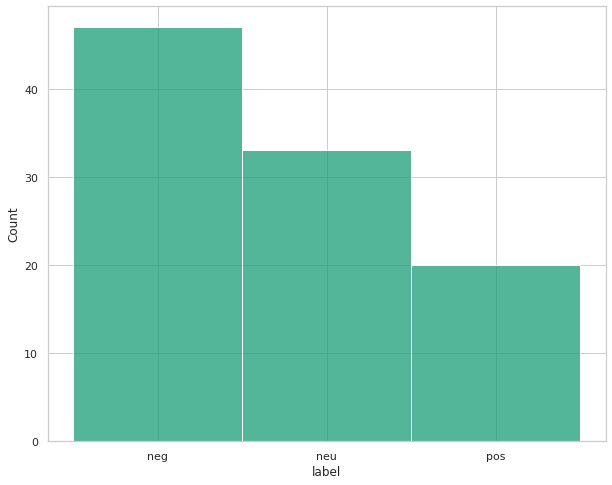

In [ ]:
sns.histplot(worldnews.label);


In [ ]:
from google.colab import files

worldnews.to_csv('worldnews.csv')
files.download('worldnews.csv')